# Cat vs. Dog Image Classification
## Exercise 1: Building a Convnet from Scratch

In this exercise, we will build a classifier model from scratch that is able to distinguish dogs from cats. We will follow these steps:

1. Explore the example data
2. Build a small convnet from scratch to solve our classification problem
3. Evaluate training and validation accuracy

Let's go!


## Explore the Example Data
Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.  
**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [1]:
!pip install zipfile36

In [4]:
pip install tensorflow

In [5]:
import os
import pandas as pd
import zipfile36 as zipfile
import numpy as np
import random
import shutil
from matplotlib import pyplot as plt
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

AttributeError: module 'tensorflow.python.data.ops.iterator_ops' has no attribute 'OwnedIterator'

In [3]:
zip_ref = zipfile.ZipFile('/content/dog-breed-identification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
os.getcwd()
base_dir = '/content/'
os.chdir(base_dir)

Ici, nous utiliserons uniquement le dossier train puisqu'il est le seul à disposer d'images avec leur label correspondant dans le fichier "label.csv".

In [5]:
print('total training dog images:', len(os.listdir('train')))

total training dog images: 10222


In [6]:
import os

folder_path = "/content/train_subset/"

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        os.remove(file_path)
print(f"Supprimé")

folder_path = "/content/test_subset/"

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        os.remove(file_path)
print(f"Supprimé")


FileNotFoundError: [Errno 2] No such file or directory: '/content/train_subset/'

Nous créons, à partir du dossier "train", un dossier "train_subset" et "test_subset" pour avoir des données d'entrainement et de test.

In [7]:
# Chemins
original_train_dir = 'train'  # <-- à adapter si besoin
train_subset_dir = 'train_subset'
test_subset_dir = 'test_subset'

# Créer les dossiers si nécessaires
os.makedirs(train_subset_dir, exist_ok=True)
os.makedirs(test_subset_dir, exist_ok=True)

# Lire le CSV
labels_df = pd.read_csv('labels.csv')  # Le fichier contient id + breed
labels_df['filename'] = labels_df['id'] + '.jpg'

# Mélanger les lignes
labels_df = labels_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculer la taille du split
total_images = len(labels_df)
train_size = int(total_images * 0.8)

# Séparer les données (80% train, 20% test)
train_df = labels_df.iloc[:train_size]
test_df = labels_df.iloc[train_size:]

# Copier les images dans les bons dossiers
for filename in train_df['filename']:
    src = os.path.join(original_train_dir, filename)
    dst = os.path.join(train_subset_dir, filename)
    if os.path.exists(src):
        shutil.copy(src, dst)

for filename in test_df['filename']:
    src = os.path.join(original_train_dir, filename)
    dst = os.path.join(test_subset_dir, filename)
    if os.path.exists(src):
        shutil.copy(src, dst)

# Vérification
print("Total images :", total_images)
print("Train split  :", len(os.listdir(train_subset_dir)))
print("Test split   :", len(os.listdir(test_subset_dir)))


Total images : 10222
Train split  : 8177
Test split   : 2045


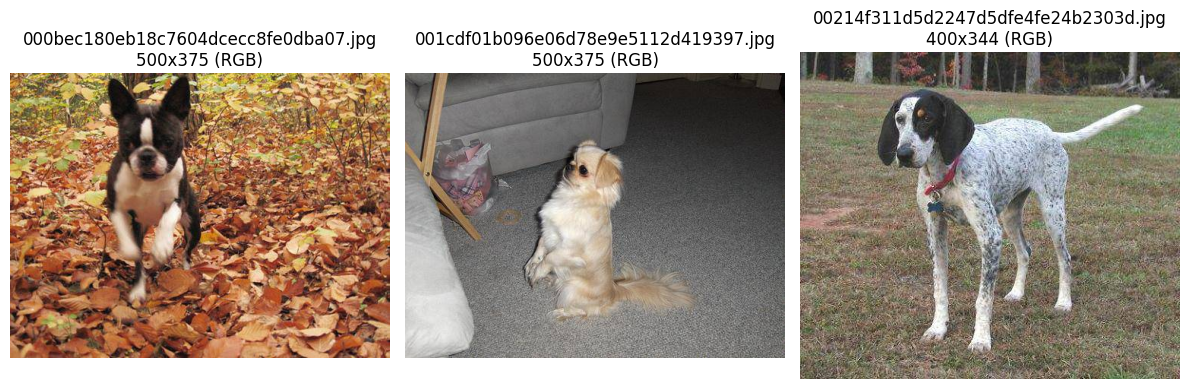

In [ ]:
# Dossier d'entraînement
train_dir = 'train_subset'

# Lister et trier les 9 premières images
image_files = sorted(os.listdir(train_dir))[:3]

# Créer une figure
plt.figure(figsize=(12, 12))

for i, img_file in enumerate(image_files):
    # Chemin complet
    img_path = os.path.join(train_dir, img_file)

    # Ouvrir l'image avec PIL
    img = Image.open(img_path)
    width, height = img.size
    mode = img.mode  # ex: RGB, L, etc.

    # Affichage
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{img_file}\n{width}x{height} ({mode})")

plt.tight_layout()
plt.show()


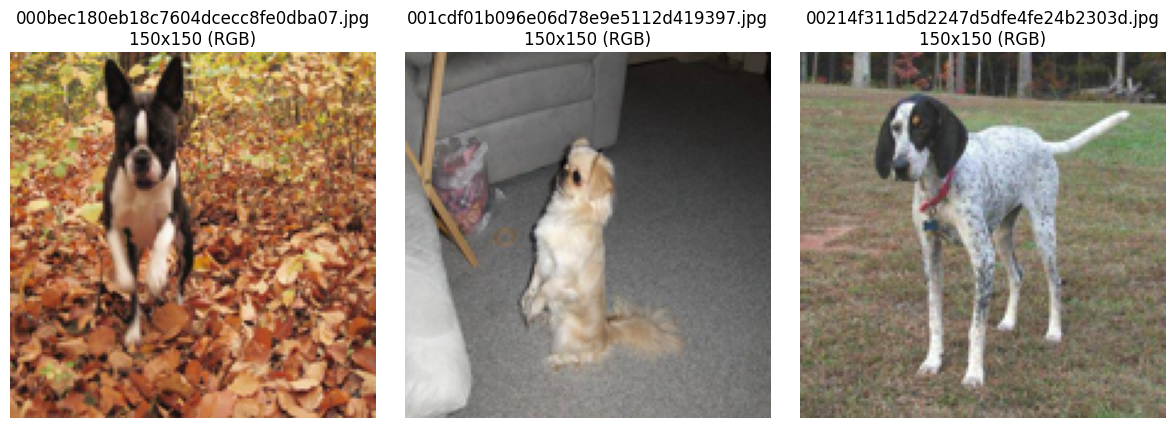

In [ ]:
# Dossier d'entraînement
train_dir = 'train_subset'

# Lister et trier les 9 premières images
image_files = sorted(os.listdir(train_dir))[:3]

# Créer une figure pour afficher les images
plt.figure(figsize=(12, 12))

for i, img_file in enumerate(image_files):
    img_path = os.path.join(train_dir, img_file)

    # Ouvrir et redimensionner l'image à 150x150
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((150, 150))

    # Affichage
    plt.subplot(3, 3, i + 1)
    plt.imshow(img_resized)
    plt.axis('off')
    plt.title(f"{img_file}\n150x150 (RGB)")

plt.tight_layout()
plt.show()

In [ ]:
# Normalisation des images d'entrainement et de test afin de rendre plus efficace le traitement des données par le réseau de neurones.

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
# Préparation des images d'entrainement en y ajoutant leur label via le fichier "label.csv" et en modifiant leur taille afin de réduire les temps de traitement

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Lire le fichier CSV
df = pd.read_csv('labels.csv')

# Ajouter l'extension pour que ça corresponde aux noms d'images
df['filename'] = df['id'] + '.jpg'

# (Optionnel) Filtrer pour ne garder que les fichiers présents dans 'train_subset/'
available_files = set(os.listdir('train_subset'))
df = df[df['filename'].isin(available_files)]

# Générateur de données avec normalisation
datagen = ImageDataGenerator(rescale=1./255)

# Créer le générateur d'images à partir du DataFrame
train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory='train_subset',
    x_col='filename',
    y_col='breed',
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle=True,
    seed=42
)


Found 8177 validated image filenames belonging to 120 classes.


In [ ]:
# Idem mais pour les images de test

# Charger les labels de validation
val_df = pd.read_csv('labels.csv')
val_df['filename'] = val_df['id'] + '.jpg'

# Vérifie que les fichiers existent
import os
available_val_files = set(os.listdir('test_subset'))
val_df = val_df[val_df['filename'].isin(available_val_files)]

# Générateur pour validation
test_gen = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='test_subset',
    x_col='filename',
    y_col='breed',
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',  # ou 'sparse', ou 'binary' selon ton cas
    shuffle=False,             # souvent False pour évaluer
    seed=42
)


Found 2045 validated image filenames belonging to 120 classes.


In [ ]:
# Création du modèle avec différents paramètre
# Ce modèle CNN prend des images 150x150x3 en entrée, applique 3 blocs convolution + max pooling pour extraire des caractéristiques, aplatit les données, utilise une couche dense de 512 neurones, puis une couche softmax pour classer l’image en 120 races de chiens

inputs = tf.keras.layers.Input(shape=(150, 150, 3))

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs = tf.keras.layers.Dense(120, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,555,608 (36.45 MB)

 Trainable params: 9,555,608 (36.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Renseigne des éléments nécéssaire à l'entrainement du modèle tels que :
# - l'optimisateur, permet d'ajuster les poids
# - la fonction de perte, minimise la perte afin d'être le plus précis possible pour reconnaitre les races des chiens
# - les métriques, permettant de suivre l'évolution de la précision de notre modèle durant son entrainement

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Etape d'entrainement de notre modèle avec les différents paramètres renseignés précédement

# Défini le nombre d'image utilisés à la fois (lots) pour entrainer notre modèle
batch_size = 20

# Calcul du nombre d'étapes pour parcourir l'ensemble des images du jeu de données d'entrainement et de test
steps_per_epoch = int(np.ceil(train_gen.samples / batch_size))
validation_steps = int(np.ceil(test_gen.samples / batch_size))

# Entrainement du modèle
history = model.fit(
    train_gen,                        # Générateur d'images d'entrainement
    epochs=15,                        # Nombre de passage sur l'ensemble des lots d'images
    steps_per_epoch=steps_per_epoch,
    validation_data=test_gen,         # Générateur d'images de test/validation
    validation_steps=validation_steps
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


409/409 ━━━━━━━━━━━━━━━━━━━━ 254s 613ms/step - accuracy: 0.0130 - loss: 4.7924 - val_accuracy: 0.0259 - val_loss: 4.6290
Epoch 2/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 255s 598ms/step - accuracy: 0.0444 - loss: 4.4524 - val_accuracy: 0.0474 - val_loss: 4.5055
Epoch 3/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 260s 592ms/step - accuracy: 0.2654 - loss: 3.2041 - val_accuracy: 0.0421 - val_loss: 5.1995
Epoch 4/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 261s 591ms/step - accuracy: 0.7776 - loss: 0.9439 - val_accuracy: 0.0416 - val_loss: 8.6407
Epoch 5/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 248s 607ms/step - accuracy: 0.9709 - loss: 0.1627 - val_accuracy: 0.0435 - val_loss: 13.8226
Epoch 6/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 254s 621ms/step - accuracy: 0.9895 - loss: 0.0901 - val_accuracy: 0.0484 - val_loss: 13.8483
Epoch 7/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 277s 658ms/step - accuracy: 0.9964 - loss: 0.0208 - val_accuracy: 0.0421 - val_loss: 13.0939
Epoch 8/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 268s 656ms/step - accuracy: 0.9870 - loss: 0

In [ ]:
# Pour sauvegarder
model.save('MPO_modele_scratch_avant_data_augmentation.h5')
model.save('MPO_modele_scratch_avant_data_augmentation.keras')

In [ ]:
def diagnostic_learning_curves():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # Accuracy
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

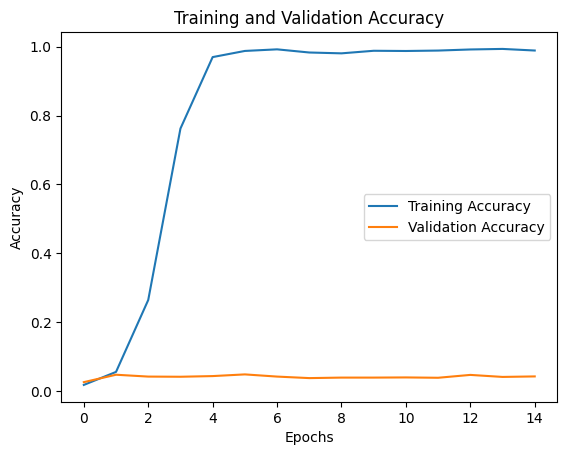

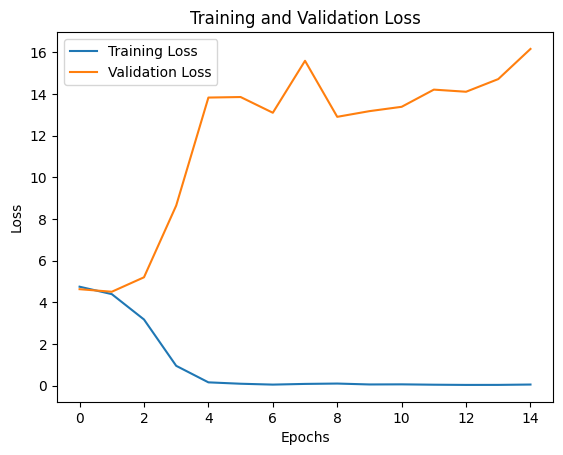

In [ ]:
diagnostic_learning_curves()

Réutilisation du modèle déjà entrainé

# Data augmentation

Pour réduire l'overfitting, nous pouvons réaliser de la data augmentation en appliquant diverse rotation d'image afin d'avoir pour 1 image source plusieurs images transformées.

In [ ]:
# Création du modèle avec différents paramètre
# Ce modèle CNN prend des images 150x150x3 en entrée, applique 3 blocs convolution + max pooling pour extraire des caractéristiques, aplatit les données, utilise une couche dense de 512 neurones, puis une couche softmax pour classer l’image en 120 races de chiens

inputs = tf.keras.layers.Input(shape=(150, 150, 3))

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs = tf.keras.layers.Dense(120, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,555,608 (36.45 MB)

 Trainable params: 9,555,608 (36.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Renseigne des éléments nécéssaire à l'entrainement du modèle tels que :
# - l'optimisateur, permet d'ajuster les poids
# - la fonction de perte, minimise la perte afin d'être le plus précis possible pour reconnaitre les races des chiens
# - les métriques, permettant de suivre l'évolution de la précision de notre modèle durant son entrainement

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Réalisation à la voler des images modifiées

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- TRAIN ---
# Lire le fichier CSV
df = pd.read_csv('labels.csv')

# Ajouter l'extension aux IDs pour correspondre aux noms de fichiers
df['filename'] = df['id'] + '.jpg'

# Garder seulement les images présentes dans 'train_subset'
available_files = set(os.listdir('train_subset'))
df = df[df['filename'].isin(available_files)]

# Créer le générateur d'images modifier à partir du DataFrame
train_gen = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory='train_subset',
    x_col='filename',
    y_col='breed',                # s'assurer que 'breed' est bien une colonne du CSV
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',     # ou 'sparse' si tu veux des entiers
    shuffle=True,
    seed=42
)


# --- VALIDATION / TEST ---
# Charger les labels
val_df = pd.read_csv('labels.csv')  # même fichier, c’est ok
val_df['filename'] = val_df['id'] + '.jpg'

# Garder seulement les fichiers présents dans le dossier de test
available_val_files = set(os.listdir('test_subset'))
val_df = val_df[val_df['filename'].isin(available_val_files)]

# Générateur de validation (sans augmentation, mais avec normalisation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='test_subset',
    x_col='filename',
    y_col='breed',
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',   # ou 'sparse' si output = int
    shuffle=False,
    seed=42
)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


In [ ]:
batch_size = 20

steps_per_epoch = int(np.ceil(train_gen.samples / batch_size))
validation_steps = int(np.ceil(test_gen.samples / batch_size))

history = model.fit(
    train_gen,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_gen,
    validation_steps=validation_steps
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


409/409 ━━━━━━━━━━━━━━━━━━━━ 266s 641ms/step - accuracy: 0.0116 - loss: 4.7931 - val_accuracy: 0.0205 - val_loss: 4.6558
Epoch 2/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 315s 624ms/step - accuracy: 0.0294 - loss: 4.5504 - val_accuracy: 0.0396 - val_loss: 4.4440
Epoch 3/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 260s 636ms/step - accuracy: 0.0898 - loss: 4.1182 - val_accuracy: 0.0577 - val_loss: 4.4401
Epoch 4/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 260s 631ms/step - accuracy: 0.3016 - loss: 2.9359 - val_accuracy: 0.0601 - val_loss: 5.0078
Epoch 5/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 260s 625ms/step - accuracy: 0.7290 - loss: 1.1220 - val_accuracy: 0.0548 - val_loss: 7.4609
Epoch 6/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 256s 611ms/step - accuracy: 0.9524 - loss: 0.2182 - val_accuracy: 0.0469 - val_loss: 10.7430
Epoch 7/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 251s 614ms/step - accuracy: 0.9827 - loss: 0.0757 - val_accuracy: 0.0553 - val_loss: 11.3311
Epoch 8/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 250s 611ms/step - accuracy: 0.9936 - loss: 0.

In [ ]:
# Pour sauvegarder
model.save('MPO_modele_scratch_apres_data_augmentation.h5')
model.save('MPO_modele_scratch_apres_data_augmentation.keras')

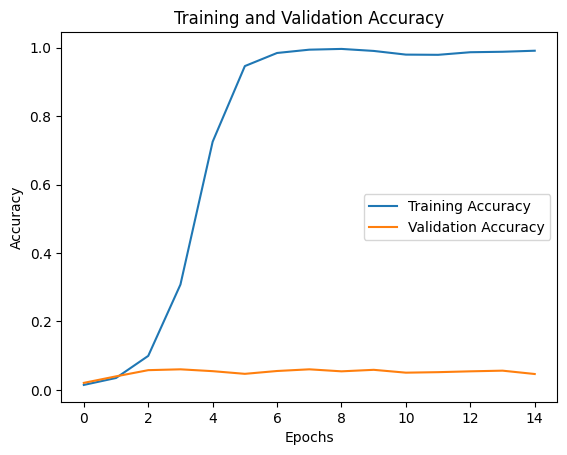

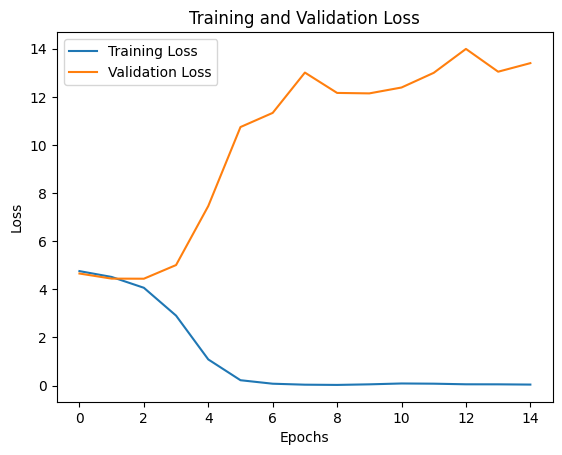

In [ ]:
diagnostic_learning_curves()

# Dropout

Notre modèle "overfit" toujours, on remarque que notre "accuracy" atteint rapidement les 98% de réussite. Nous allons donc utiliser la méthode de "Dropout" donc nous allons couper certains noeuds de neurones du reste pour éviter le surapprentissage.

In [8]:
# Changement de réseau de neurones et de quelques paramètre à la vue des résultats précédents


from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2

img_input = layers.Input(shape=(150, 150, 3))

# Bloc 1
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(img_input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2)(x)

# Bloc 2
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2)(x)

# Bloc 3
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2)(x)

# Bloc 4
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2)(x)

# Global Average Pooling au lieu de Flatten
x = layers.GlobalAveragePooling2D()(x)

# Dense
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Sortie
output = layers.Dense(120, activation='softmax')(x)

# Modèle
model = Model(img_input, output)
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0005), metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 583,480 (2.23 MB)

 Trainable params: 582,520 (2.22 MB)

 Non-trainable params: 960 (3.75 KB)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os

# --- DATA AUGMENTATION pour l'entraînement ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# --- TRAIN ---
# Lire le fichier CSV
df = pd.read_csv('labels.csv')

# Ajouter l'extension aux IDs pour correspondre aux noms de fichiers
df['filename'] = df['id'] + '.jpg'

# Garder seulement les images présentes dans 'train_subset'
available_files = set(os.listdir('train_subset'))
df = df[df['filename'].isin(available_files)]

# Générateur d'entraînement
train_gen = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory='train_subset',
    x_col='filename',
    y_col='breed',
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# --- VALIDATION / TEST ---
val_df = pd.read_csv('labels.csv')
val_df['filename'] = val_df['id'] + '.jpg'

available_val_files = set(os.listdir('test_subset'))
val_df = val_df[val_df['filename'].isin(available_val_files)]

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='test_subset',
    x_col='filename',
    y_col='breed',
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


In [ ]:
batch_size = 64

steps_per_epoch = int(np.ceil(train_gen.samples / batch_size))
validation_steps = int(np.ceil(test_gen.samples / batch_size))

history = model.fit(
    train_gen,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_gen,
    validation_steps=validation_steps
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.0072 - loss: 5.3393 - val_accuracy: 0.0156 - val_loss: 5.3008
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.0140 - loss: 5.1273 - val_accuracy: 0.0078 - val_loss: 5.8213
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.0187 - loss: 5.0351 - val_accuracy: 0.0031 - val_loss: 6.0462
Epoch 4/30
 25/128 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.0404 - loss: 4.9242

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


128/128 ━━━━━━━━━━━━━━━━━━━━ 50s 383ms/step - accuracy: 0.0417 - loss: 4.9216 - val_accuracy: 0.0063 - val_loss: 6.0194
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.0241 - loss: 4.9054 - val_accuracy: 0.0156 - val_loss: 5.0342
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.0243 - loss: 4.8683 - val_accuracy: 0.0219 - val_loss: 4.8125
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.0392 - loss: 4.7361 - val_accuracy: 0.0312 - val_loss: 4.7667
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 49s 376ms/step - accuracy: 0.0270 - loss: 4.8019 - val_accuracy: 0.0250 - val_loss: 4.8044
Epoch 9/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.0294 - loss: 4.7429 - val_accuracy: 0.0266 - val_loss: 4.7358
Epoch 10/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.0343 - loss: 4.6519 - val_accuracy: 0.0266 - val_loss: 4.7875
Epoch 11/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.0351 - loss: 4.6070 - val_accuracy:

In [ ]:
# Pour sauvegarder
model.save('MPO_modele_scratch_dropout.h5')
model.save('MPO_modele_scratch_dropout.keras')

## Evaluate the Results

Let's evaluate the results of model training with data augmentation and dropout:

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd

# Charger les classes depuis le CSV
df = pd.read_csv("labels.csv")
class_names = sorted(df['breed'].unique())

# Charger le modèle
model = load_model("MPO_modele_scratch_dropout.keras")

# Préparer une image
img_path = "/content/border_terrier.jpg"
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Prédiction
predictions = model.predict(img_array)[0]

# Indices triés par probabilité décroissante
top_indices = predictions.argsort()[-3:][::-1]

print("Top 3 prédictions :")
for idx in top_indices:
    print(f"{class_names[idx]} : {predictions[idx]*100:.2f}%")


In [ ]:
diagnostic_learning_curves()

Modèle : avant_augmentation


103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step
3 races les mieux prédites :
 - entlebucher: 34.78% de bonnes prédictions
 - clumber: 26.67% de bonnes prédictions
 - leonberg: 21.74% de bonnes prédictions

----------------------------------------

Modèle : apres_augmentation


103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step
3 races les mieux prédites :
 - otterhound: 50.00% de bonnes prédictions
 - pomeranian: 26.67% de bonnes prédictions
 - bluetick: 23.81% de bonnes prédictions

----------------------------------------

Modèle : avec_dropout


103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step
3 races les mieux prédites :
 - leonberg: 43.48% de bonnes prédictions
 - japanese_spaniel: 38.46% de bonnes prédictions
 - curly-coated_retriever: 30.00% de bonnes prédictions

----------------------------------------



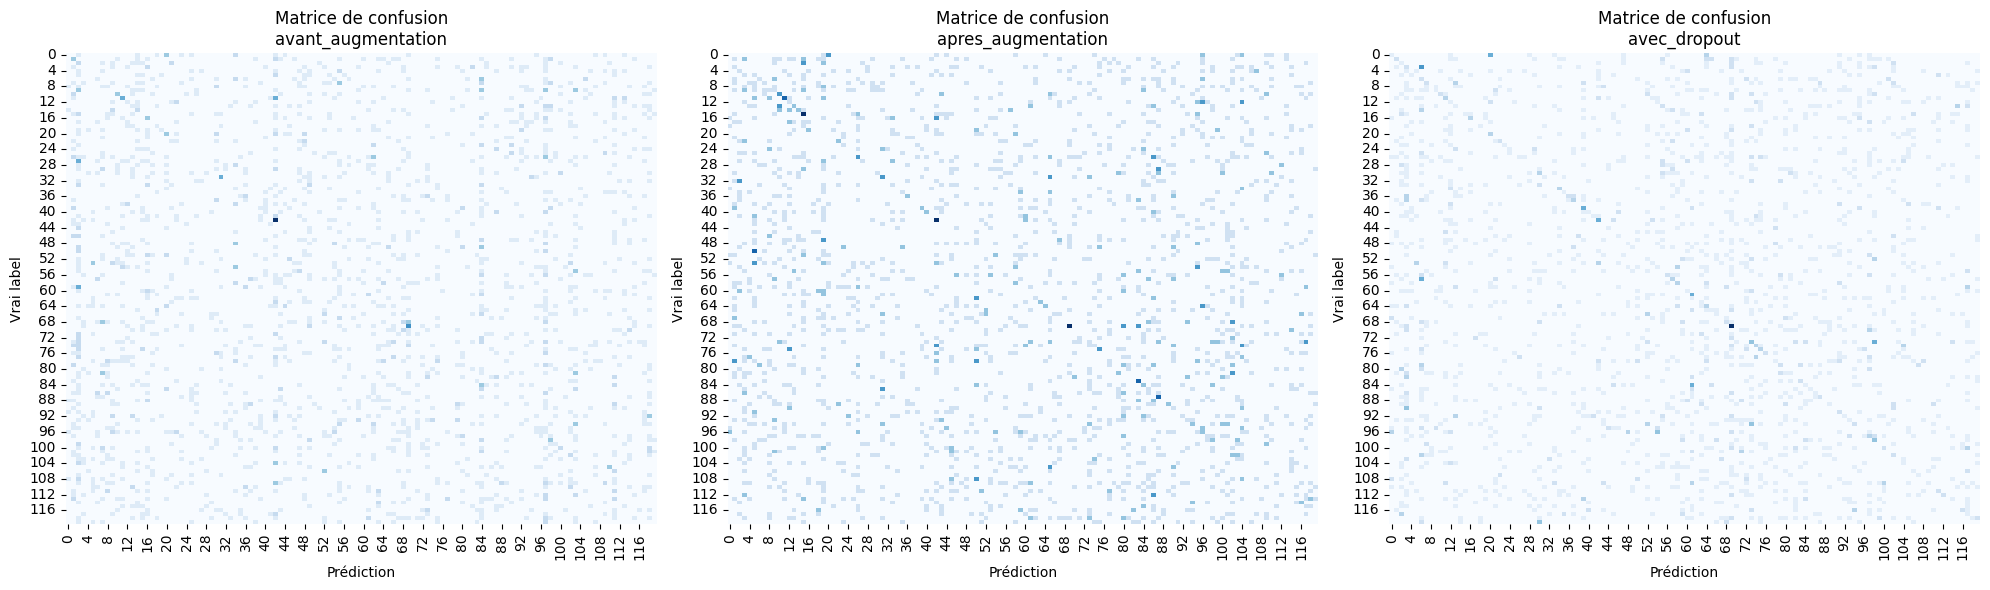

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

models_paths = {
    "avant_augmentation": "/content/MPO_modele_scratch_avant_data_augmentation.h5",
    "apres_augmentation": "/content/MPO_modele_scratch_apres_data_augmentation.h5",
    "avec_dropout": "/content/MPO_modele_scratch_dropout.h5"
}

y_true = np.array(test_gen.classes)
class_names = list(test_gen.class_indices.keys())

plt.figure(figsize=(20, 6))

for i, (name, path) in enumerate(models_paths.items(), 1):
    print(f"Modèle : {name}")
    model = keras.models.load_model(path)

    # Prédictions
    y_proba = model.predict(test_gen)
    y_pred = y_proba.argmax(axis=1)

    # Matrice de confusion
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.subplot(1, 3, i)
    sns.heatmap(conf_mat, cmap='Blues', cbar=False)
    plt.title(f"Matrice de confusion\n{name}")
    plt.xlabel('Prédiction')
    plt.ylabel('Vrai label')

    # Calcul précision par classe
    class_accuracies = {}
    for j, class_name in enumerate(class_names):
        idxs = np.where(y_true == j)[0]
        if len(idxs) == 0:
            continue
        acc = accuracy_score(y_true[idxs], y_pred[idxs])
        class_accuracies[class_name] = acc

    # Tri décroissant des précisions
    best_classes = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)

    print("3 races les mieux prédites :")
    for race, acc in best_classes[:3]:
        print(f" - {race}: {acc:.2%} de bonnes prédictions")
    print("\n" + "-"*40 + "\n")

plt.tight_layout()
plt.show()
